In [1]:
import torch
import torch.nn as nn

class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()

        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, 30 * 64 * 64)

        self.conv1 = nn.Conv2d(30, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 30, kernel_size=3, padding=1)

        self.upsample = nn.Upsample(size=(250, 250), mode='bilinear', align_corners=True)

    def forward(self, x, capture_features=False):
        features = []

        # — Global MLP projection to (batch,30*64*64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1,30,64,64)

        # — Capture the *true* time‐frames (coarse)
        if capture_features:
            features.append(x.clone().detach())

        # — Then your convolutions (abstract feature‐maps)
        x = F.relu(self.conv1(x))
        if capture_features: features.append(x.clone().detach())

        x = F.relu(self.conv2(x))
        if capture_features: features.append(x.clone().detach())

        x = F.relu(self.conv3(x))
        if capture_features: features.append(x.clone().detach())

        x = F.relu(self.conv4(x))
        if capture_features: features.append(x.clone().detach())

        x = F.relu(self.conv5(x))
        if capture_features: features.append(x.clone().detach())

        # — Upsample
        x = self.upsample(x)

        if capture_features:
            return x, features
        else:
            return x



Define the function SF: solid fraction

In [4]:
def compute_final_solid_fraction(x_input, model, device):
    """
    x_input: list or np.array of shape (5,) - physical input parameters
    model: trained CNN model
    device: torch device
    """
    model.eval()
    x_tensor = torch.tensor([x_input], dtype=torch.float32).to(device)  # shape: [1, 5]

    with torch.no_grad():
        pred = model(x_tensor)  # shape: [1, 30, 250, 250]
        final_frame = pred[0, -1, :, :]  # take final frame
        solid_fraction = final_frame.mean().item()  # scalar mean
        return solid_fraction
results = []
# === Define the search space for 5 physical input parameters ===
search_space = {
    'ΔT0': (-0.9, -0.1),           # Initial undercooling
    'c': (0.01, 0.1),            # Anisotropy strength
    'N': (1, 10),                # Seed size or number
    'θ': (0, 90),                # Orientation in degrees
    'r0': (0.05, 0.2)            # Seed radius or smoothing term
}
import random
import numpy as np

def sample_random_input(space):
    return [
        round(np.random.uniform(*space['ΔT0']), 3),
        round(np.random.uniform(*space['c']), 3),
        random.randint(space['N'][0], space['N'][1]),
        round(np.random.uniform(*space['θ']), 2),
        round(np.random.uniform(*space['r0']), 3)
    ]

for i in range(1000):
    x = sample_random_input(search_space)
    score = compute_final_solid_fraction(x, model, DEVICE)
    results.append((x, score))
    print(f"Trial {i+1:03d}: Input = {x}, Solid Fraction = {score:.4f}")

# Find best result
best_input, best_score = sorted(results, key=lambda x: -x[1])[0]
print("\n🎯 Best Input:", best_input)
print("🧊 Max Solid Fraction:", round(best_score, 4))


Trial 001: Input = [-0.536, 0.034, 8, 52.73, 0.1], Solid Fraction = 0.1805
Trial 002: Input = [-0.473, 0.058, 5, 83.45, 0.088], Solid Fraction = 0.2789
Trial 003: Input = [-0.186, 0.088, 4, 27.41, 0.126], Solid Fraction = 0.0309
Trial 004: Input = [-0.505, 0.042, 2, 4.56, 0.064], Solid Fraction = 0.5686
Trial 005: Input = [-0.592, 0.011, 7, 81.25, 0.061], Solid Fraction = 0.2692
Trial 006: Input = [-0.158, 0.043, 6, 7.33, 0.126], Solid Fraction = 0.0306
Trial 007: Input = [-0.155, 0.018, 6, 34.32, 0.106], Solid Fraction = 0.0308
Trial 008: Input = [-0.712, 0.019, 5, 26.79, 0.107], Solid Fraction = 0.6334
Trial 009: Input = [-0.586, 0.019, 10, 36.15, 0.187], Solid Fraction = 0.2072
Trial 010: Input = [-0.294, 0.087, 7, 78.12, 0.11], Solid Fraction = 0.0858
Trial 011: Input = [-0.801, 0.1, 10, 84.15, 0.129], Solid Fraction = 0.3419
Trial 012: Input = [-0.392, 0.057, 5, 19.12, 0.063], Solid Fraction = 0.1432
Trial 013: Input = [-0.497, 0.048, 6, 33.4, 0.148], Solid Fraction = 0.1866
Trial

KeyboardInterrupt: 

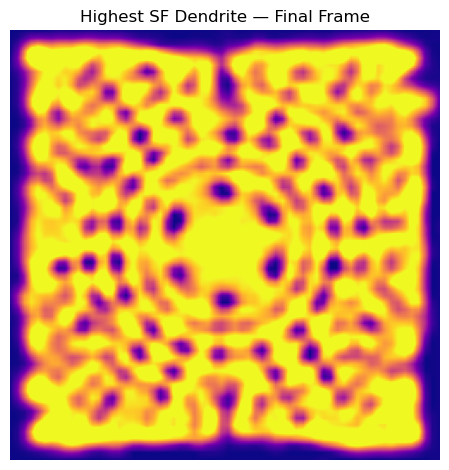

In [5]:
best_input_tensor = torch.tensor([best_input], dtype=torch.float32).to(DEVICE)

with torch.no_grad():
    pred = model(best_input_tensor)  # shape: [1, 30, 250, 250]
    xi_series = pred.squeeze(0).cpu().numpy()  # shape: [30, 250, 250]

# Plot final frame
plt.imshow(xi_series[-1], cmap='plasma', origin='lower', vmin=0, vmax=1)
plt.title(f"Highest SF Dendrite — Final Frame")
plt.axis('off')
plt.tight_layout()
plt.show()


BRANCHINESS!!!

In [5]:
def compute_branchiness(x_input, model, device):
    """
    Returns total interface length (branchiness) of final frame.
    Lower is better (less dendritic).
    """
    model.eval()
    x_tensor = torch.tensor([x_input], dtype=torch.float32).to(device)

    with torch.no_grad():
        pred = model(x_tensor)
        final_frame = pred[0, -1, :, :].cpu().numpy()

        gx, gy = np.gradient(final_frame)
        grad_mag = np.sqrt(gx**2 + gy**2)
        branchiness_score = grad_mag.sum()
        return branchiness_score


In [6]:
results_branchiness = []

for i in range(100):
    x = sample_random_input(search_space)
    score = compute_branchiness(x, model, DEVICE)
    results_branchiness.append((x, score))
    print(f"[{i+1:03d}] Input = {x}, Branchiness Score = {score:.2f}")

# Get best (least dendritic) result
best_input_branch, best_branchiness = sorted(results_branchiness, key=lambda x: x[1])[0]

print("\n🌱 Least Dendritic Input:", best_input_branch)
print("🧩 Minimum Branchiness Score:", round(best_branchiness, 2))


[001] Input = [-0.166, 0.085, 9, 13.74, 0.097], Branchiness Score = 206.64
[002] Input = [-0.873, 0.081, 2, 24.59, 0.065], Branchiness Score = 5147.65
[003] Input = [-0.86, 0.029, 4, 64.41, 0.115], Branchiness Score = 5684.46
[004] Input = [-0.709, 0.043, 7, 33.34, 0.065], Branchiness Score = 4006.60
[005] Input = [-0.886, 0.032, 3, 19.66, 0.171], Branchiness Score = 5351.05
[006] Input = [-0.699, 0.085, 2, 87.0, 0.082], Branchiness Score = 5260.15
[007] Input = [-0.415, 0.046, 5, 78.87, 0.13], Branchiness Score = 1637.02
[008] Input = [-0.521, 0.087, 5, 20.83, 0.163], Branchiness Score = 922.75
[009] Input = [-0.319, 0.058, 7, 0.66, 0.108], Branchiness Score = 187.06
[010] Input = [-0.112, 0.028, 6, 2.58, 0.056], Branchiness Score = 199.25
[011] Input = [-0.259, 0.016, 1, 55.84, 0.197], Branchiness Score = 2184.02
[012] Input = [-0.224, 0.065, 6, 37.85, 0.068], Branchiness Score = 186.04
[013] Input = [-0.245, 0.025, 10, 8.64, 0.057], Branchiness Score = 277.30
[014] Input = [-0.532, 

KeyboardInterrupt: 

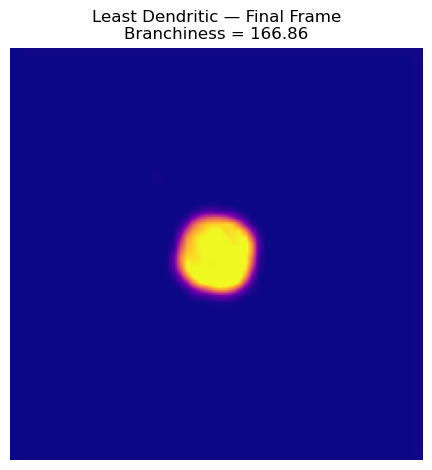

In [9]:
best_input_tensor = torch.tensor([best_input_branch], dtype=torch.float32).to(DEVICE)

with torch.no_grad():
    pred = model(best_input_tensor)
    xi_series = pred.squeeze(0).cpu().numpy()

plt.imshow(xi_series[-1], cmap='plasma', origin='lower', vmin=0, vmax=1)
plt.title(f"Least Dendritic — Final Frame\nBranchiness = {best_branchiness:.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()


Is there a relationship between branchiness and SF?

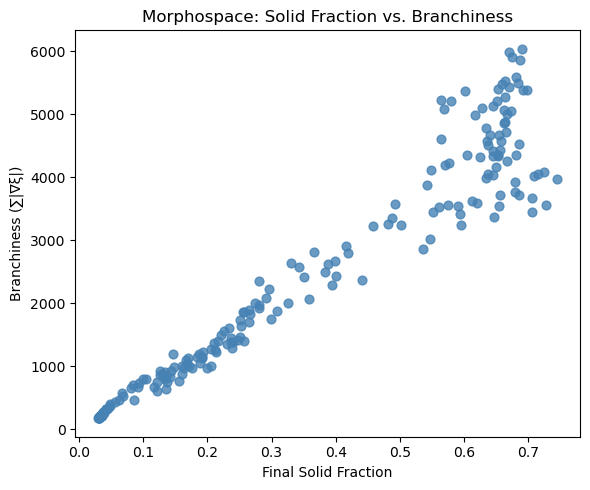

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random

# === 1) (Re)define the search space and sampler if needed ===
search_space = {
    'ΔT0': (-0.9, -0.1),           # Initial undercooling
    'c': (0.01, 0.1),            # Anisotropy strength
    'N': (1, 10),                # Seed size or number
    'θ': (0, 90),                # Orientation in degrees
    'r0': (0.05, 0.2)            # Seed radius or smoothing term
}
def sample_random_input(space):
    return [
        round(np.random.uniform(*space['ΔT0']), 3),
        round(np.random.uniform(*space['c']), 3),
        random.randint(space['N'][0], space['N'][1]),
        round(np.random.uniform(*space['θ']), 2),
        round(np.random.uniform(*space['r0']), 3),
    ]

# === 2) Collect data (reuse your existing metric functions) ===
n_samples = 200
data = []
for _ in range(n_samples):
    x  = sample_random_input(search_space)
    sf = compute_final_solid_fraction(x, model, DEVICE)
    br = compute_branchiness(x, model, DEVICE)
    data.append((x, sf, br))

solid_fracs = [d[1] for d in data]
branchiness = [d[2] for d in data]

# === 3) Plot morphospace without coloring by θ ===
plt.figure(figsize=(6,5))
plt.scatter(
    solid_fracs,
    branchiness,
    color='steelblue',  # single color
    s=40,
    alpha=0.8
)
plt.xlabel("Final Solid Fraction")
plt.ylabel("Branchiness (∑|∇ξ|)")
plt.title("Morphospace: Solid Fraction vs. Branchiness")
plt.tight_layout()
plt.show()

Plotting Max/Min branchiness vs Max solid fraction

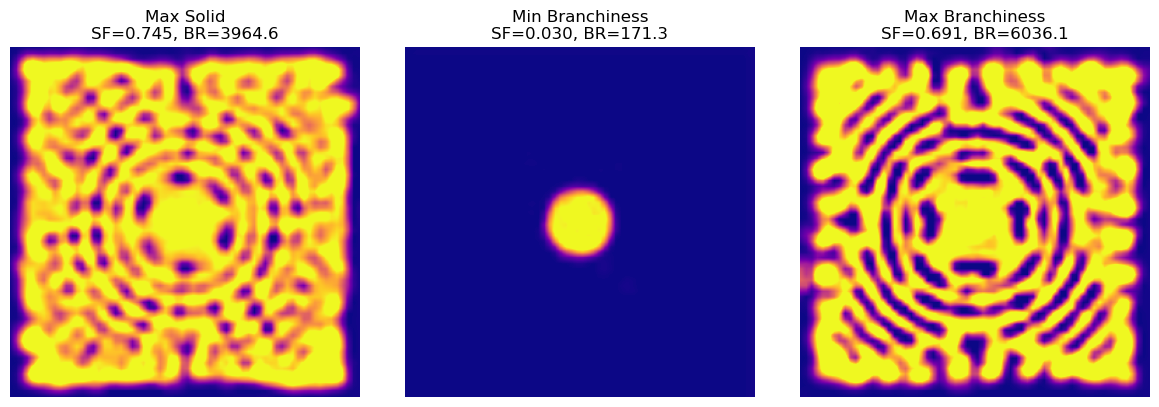

In [11]:
import matplotlib.pyplot as plt

# 1) Find the three extremes from your sampled data
# (Assuming you still have `data = [(x, sf, br), …]`)
best_solid      = max(data, key=lambda d: d[1])
least_branchy  = min(data, key=lambda d: d[2])
most_branchy   = max(data, key=lambda d: d[2])

def get_final_frame(x):
    with torch.no_grad():
        pred = model(torch.tensor([x], dtype=torch.float32).to(DEVICE))
    return pred[0, -1].cpu().numpy()

frames = [
    (best_solid,    "Max Solid"),
    (least_branchy, "Min Branchiness"),
    (most_branchy,  "Max Branchiness")
]

# 2) Plot montage
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, ((x, sf, br), label) in zip(axes, frames):
    img = get_final_frame(x)
    ax.imshow(img, cmap='plasma', origin='lower', vmin=0, vmax=1)
    ax.set_title(f"{label}\nSF={sf:.3f}, BR={br:.1f}")
    ax.axis('off')

plt.tight_layout()
plt.show()
